# Аффинитивный анализ чеков покупок



## Data Preprocessing and EDA

In [ ]:
! pip install --index-url https://test.pypi.org/simple/ PyARMViz

Looking in indexes: https://test.pypi.org/simple/


In [ ]:

import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from PyARMViz import PyARMViz

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
from openpyxl import load_workbook
import os
directory = 'чеки.xlsx'
wb = load_workbook(directory)
wb.active = 0
ws = wb.active
data = pd.DataFrame(ws.values)

In [ ]:
data = data.rename(columns={0:"Transaction",1:"date_time", 2:"Item"})

In [ ]:
data = data.drop(0)

In [ ]:
data.head()

,Transaction,date_time,Item,3,4,5,6,7
1,1701,2023-11-04 00:00:00,Чак-Чак,1,шт.,60,60,399
2,1701,2023-11-04 00:00:00,Сэндвич,1,шт.,249,249,None
3,1701,2023-11-04 00:00:00,Сырок,2,шт.,45,90,None
4,1702,2023-09-05 00:00:00,Молоко,2,шт.,80,160,395
5,1702,2023-09-05 00:00:00,Хлеб,1,шт.,35,35,None


Нам понадобятся только транзакция, товар и дата-время. Изучим, на примере 10 самых продаваемых продуктов в магазине вместе с Булкой, используя сетевую диаграмму.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


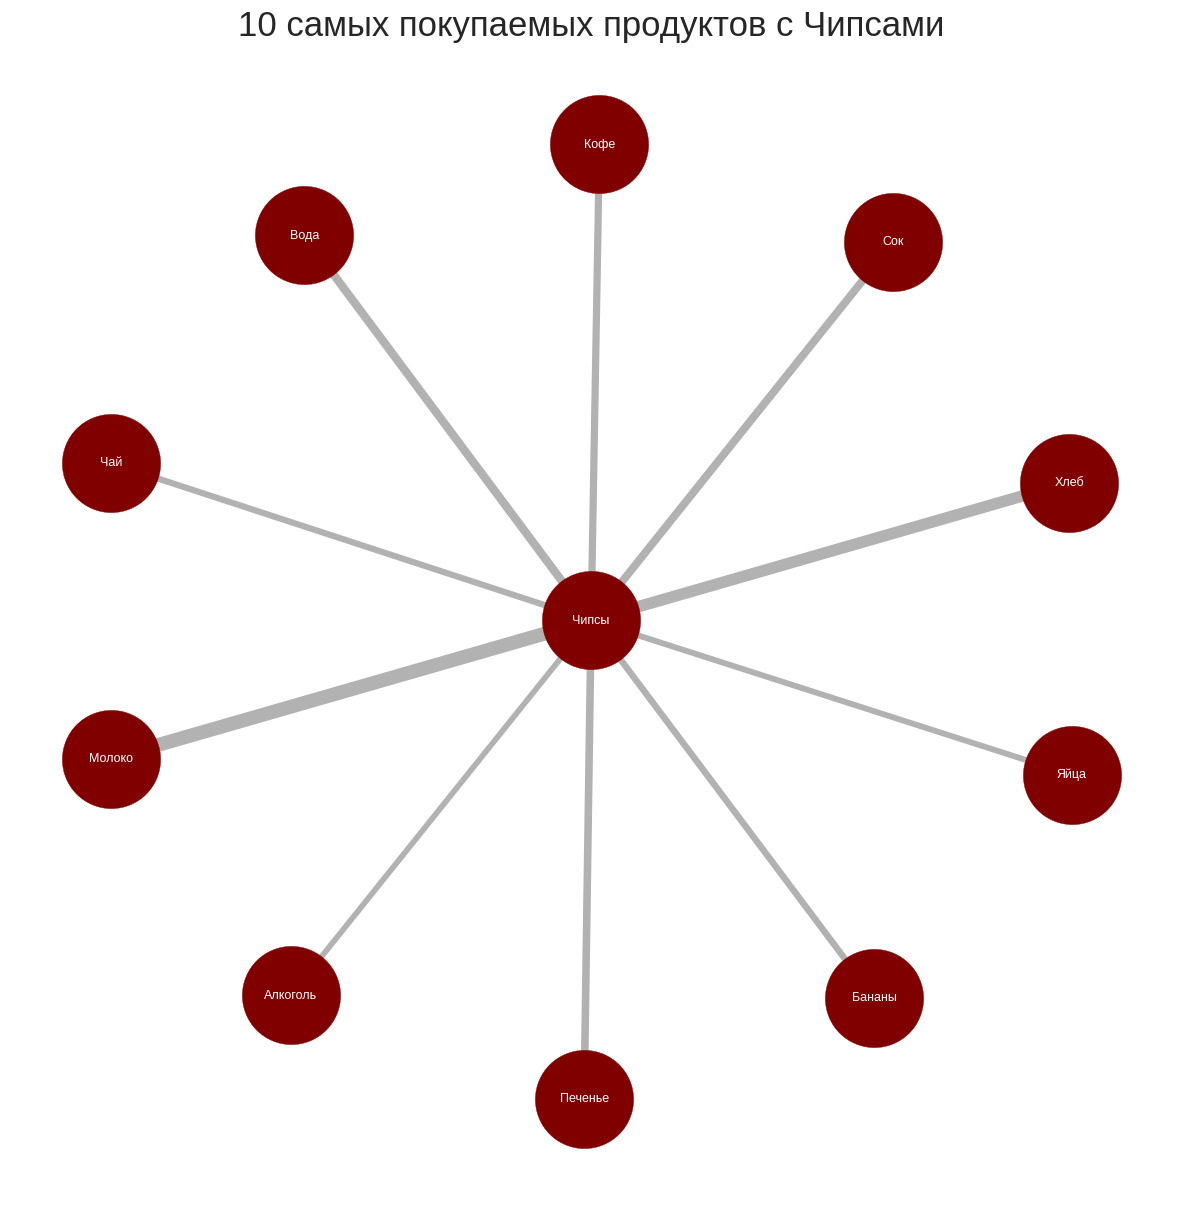

In [ ]:
data = data.drop_duplicates(['Transaction', 'Item'])
data_vis = data.copy()
df_network_first = data_vis.groupby("Item").sum().sort_values("Transaction", ascending=False).reset_index()
product = "Чипсы"
df_network_first["Type"] = product
df_network_first = df_network_first.truncate(before=-1, after=10) # top 30
plt.rcParams['figure.figsize']=(15,15)
j = 0
weight = []
for i, y in reversed(list(enumerate(df_network_first['Transaction']))):
    weight.append(y)
    j+=1
weight = weight[::-1]
df_network_first = df_network_first.drop(df_network_first[df_network_first['Item'] == product].index)
first_choice = nx.from_pandas_edgelist(df_network_first, source='Type', target="Item")
weights = [10*i/max(weight) for i in weight]
pos = nx.spring_layout(first_choice)
nx.draw_networkx_nodes(first_choice, pos, node_size=5000, node_color="maroon")
nx.draw_networkx_edges(first_choice, pos, width=weights, alpha=0.3, edge_color='black')
nx.draw_networkx_labels(first_choice, pos, font_size=9, font_family='sans-serif', font_color = 'white')
plt.axis('off')
plt.grid()
plt.title('10 самых покупаемых продуктов с Чипсами', fontsize=25)
plt.show()

## Моделирование данных

Смоделируем алгоритм Apriori.
Сначала сгенерируем набор часто используемых элементов, а затем правила ассоциации, используя набор часто используемых элементов. Нам нужно убедиться, что мы сгенерировали матрицу со значениями 0/1, представляющими наличие транзакции этого элемента.

In [ ]:
from mlxtend.frequent_patterns import association_rules, apriori

def encoder(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

apriori_data = data.groupby(['Transaction','Item'])['Item'].count().reset_index(name ='Count')
apriori_basket = apriori_data.pivot_table(index = 'Transaction', columns = 'Item', values = 'Count', aggfunc = 'sum').fillna(0)
apriori_basket_set = apriori_basket.applymap(encoder)
apriori_basket_set.head()

Item,BIG ассорти закусок,Авокадо,Алкоголь,Алкоголь,Апельсины,Ассорти орехово-фруктовое,Банан,Бананы,Баранина,Баранки,...,Шоколадное печенье,Шоколадные шарики,Штаны,Шторы,Эклеры,Яблоки,Яблоко,Яблочный пирог,Яйца,Яйцо
Transaction,,,,,,,,,,,,,,,,,,,,,
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Проанализируем правила с min_support 5%, а затем для 1% соответственно. Оба используют метрику lift.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
f_items = apriori(apriori_basket_set, min_support = 0.05, use_colnames = True)
f_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   19 non-null     float64
 1   itemsets  19 non-null     object 
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 0.05, num_itemsets=len(apriori_basket_set))
apriori_rules.sort_values('confidence', ascending = False, inplace = True)
apriori_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(Яйца),(Молоко),0.081851,0.149466,0.053381,0.652174,4.363354,0.041147,2.445285,0.839535
0,(Хлеб),(Молоко),0.131673,0.149466,0.074733,0.567568,3.797297,0.055052,1.966859,0.848361
1,(Молоко),(Хлеб),0.149466,0.131673,0.074733,0.500000,3.797297,0.055052,1.736655,0.866109
2,(Молоко),(Яйца),0.149466,0.081851,0.053381,0.357143,4.363354,0.041147,1.428233,0.906276


In [ ]:
f_items = apriori(apriori_basket_set, min_support = 0.01, use_colnames = True)
f_items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.010676,(Авокадо)
1,0.056940,(Алкоголь)
2,0.024911,(Апельсины)
3,0.092527,(Бананы)
4,0.035587,(Батончик)
...,...,...
568,0.010676,"(Печенье, Колбаса, Сыр, Молоко, Яйца, Хлеб)"
569,0.010676,"(Колбаса, Сыр, Молоко, Сахар, Яйца, Хлеб)"
570,0.010676,"(Котлеты, Печенье, Сыр, Молоко, Яйца, Хлеб)"
571,0.010676,"(Бананы, Колбаса, Сыр, Яйца, Сахар, Молоко, Хлеб)"


In [ ]:
pairs = [frozenset({'Молоко', 'Хлеб'}),
 frozenset({'Молоко', 'Яйца'}),
 frozenset({'Молоко', 'Яблоки'}),
 frozenset({'Бананы', 'Молоко'}),
 frozenset({'Молоко', 'Сыр'}),
 frozenset({'Колбаса', 'Молоко'}),
 frozenset({'Колбаса', 'Яйца'}),
 frozenset({'Хлеб', 'Яйца'}),
 frozenset({'Бананы', 'Яйца'}),
 frozenset({'Колбаса', 'Сыр'})]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
unique_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
unique_list = []
for i in pairs:
  l_i = list(i)
  unique_list += l_i
unique_list = list(set(unique_list))
unique_trans = []
for i in unique_list:
  unique_trans.append(set(data_vis[data_vis['Item'] == i]["Transaction"].to_list()))
dict_trans = {unique_list[i]:unique_trans[i] for i in range(len(unique_list))}
height = []
for i in pairs:
  l_i = list(i)
  height.append(len(dict_trans[l_i[0]] & dict_trans[l_i[1]]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pairs = [str(list(i)) for i in pairs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_plot = pd.DataFrame({"Pairs":pairs,"Number of Transaction":height})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Pairs,Number of Transaction
0,"['Хлеб', 'Молоко']",21
1,"['Молоко', 'Яйца']",15
2,"['Молоко', 'Яблоки']",11
3,"['Молоко', 'Бананы']",10
4,"['Молоко', 'Сыр']",10
5,"['Молоко', 'Колбаса']",9
6,"['Яйца', 'Колбаса']",9
7,"['Хлеб', 'Яйца']",9
8,"['Яйца', 'Бананы']",8
9,"['Колбаса', 'Сыр']",8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Pairs', ylabel='Number of Transaction'>

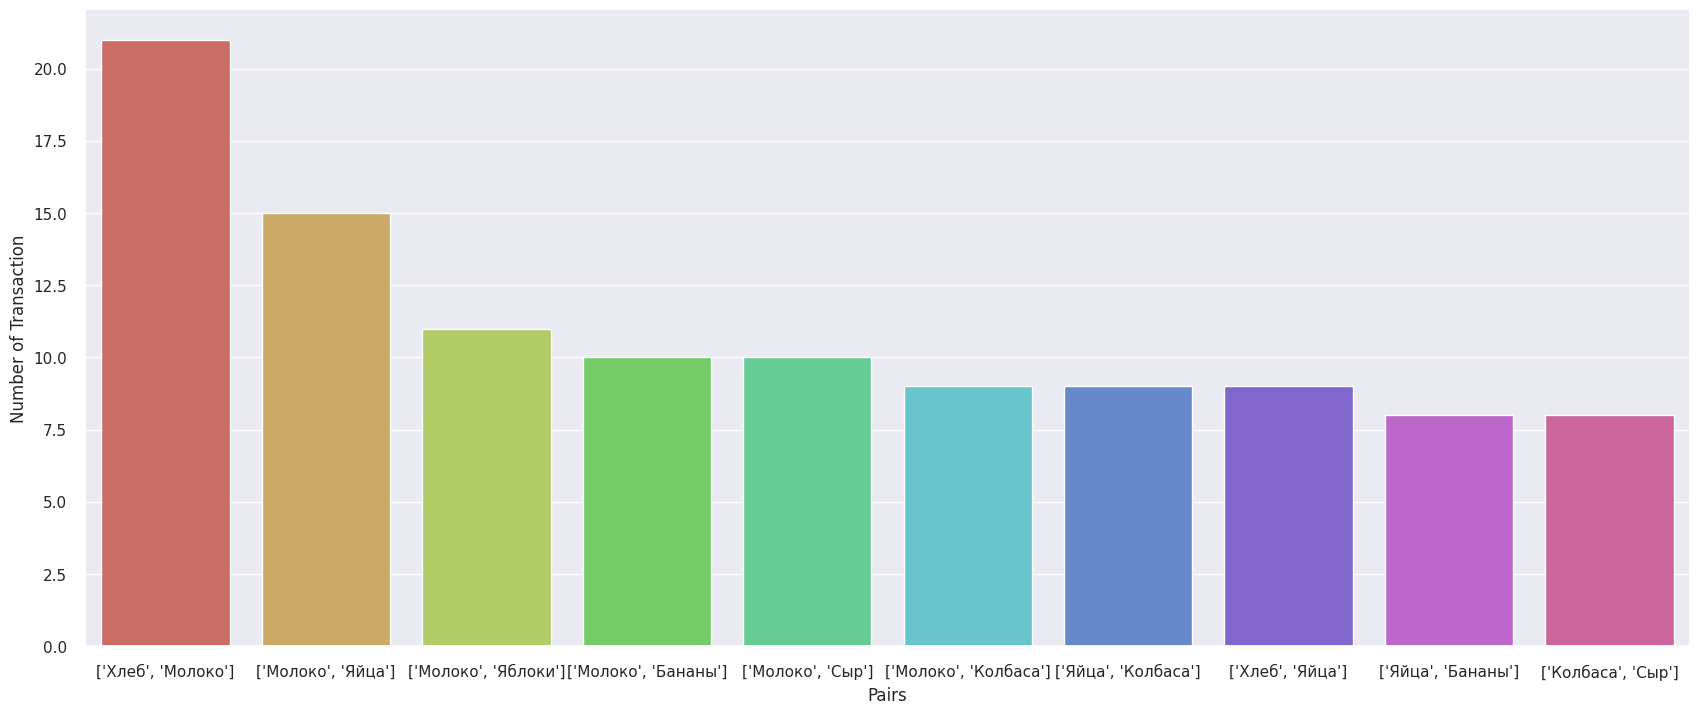

In [ ]:
sns.color_palette("Paired")
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.barplot(df_plot,x = "Pairs",y = "Number of Transaction",palette = "hls")

In [ ]:

apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 0.01, num_itemsets=len(apriori_basket_set))
apriori_rules.sort_values('confidence', ascending = False, inplace = True)
apriori_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4406,"(Печенье, Хлеб, Котлеты)","(Яйца, Колбаса)",0.010676,0.032028,0.010676,1.000000,31.222222,0.010334,inf,0.978417
2609,"(Хлеб, Котлеты)","(Печенье, Молоко)",0.010676,0.028470,0.010676,1.000000,35.125000,0.010372,inf,0.982014
5466,"(Колбаса, Хлеб, Макароны)","(Молоко, Яйца, Бананы)",0.010676,0.021352,0.010676,1.000000,46.833333,0.010448,inf,0.989209
3590,"(Колбаса, Хлеб, Сахар, Бананы)",(Сыр),0.010676,0.071174,0.010676,1.000000,14.050000,0.009916,inf,0.938849
6717,"(Яблоки, Курица)","(Молоко, Бананы, Хлеб, Колбаса, Яйца)",0.010676,0.017794,0.010676,1.000000,56.200000,0.010486,inf,0.992806
...,...,...,...,...,...,...,...,...,...,...
979,(Молоко),"(Яйца, Макароны)",0.149466,0.014235,0.010676,0.071429,5.017857,0.008549,1.061593,0.941423
968,(Молоко),"(Сыр, Макароны)",0.149466,0.014235,0.010676,0.071429,5.017857,0.008549,1.061593,0.941423
4996,(Молоко),"(Печенье, Яйца, Сыр, Котлеты)",0.149466,0.010676,0.010676,0.071429,6.690476,0.009080,1.065426,1.000000
955,(Молоко),"(Лук, Хлеб)",0.149466,0.010676,0.010676,0.071429,6.690476,0.009080,1.065426,1.000000


## Визуализация данных для ассоциативных правил

Сгенерируем тепловую карту ассоциативных правил для минимального порога поддержки в 1%.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


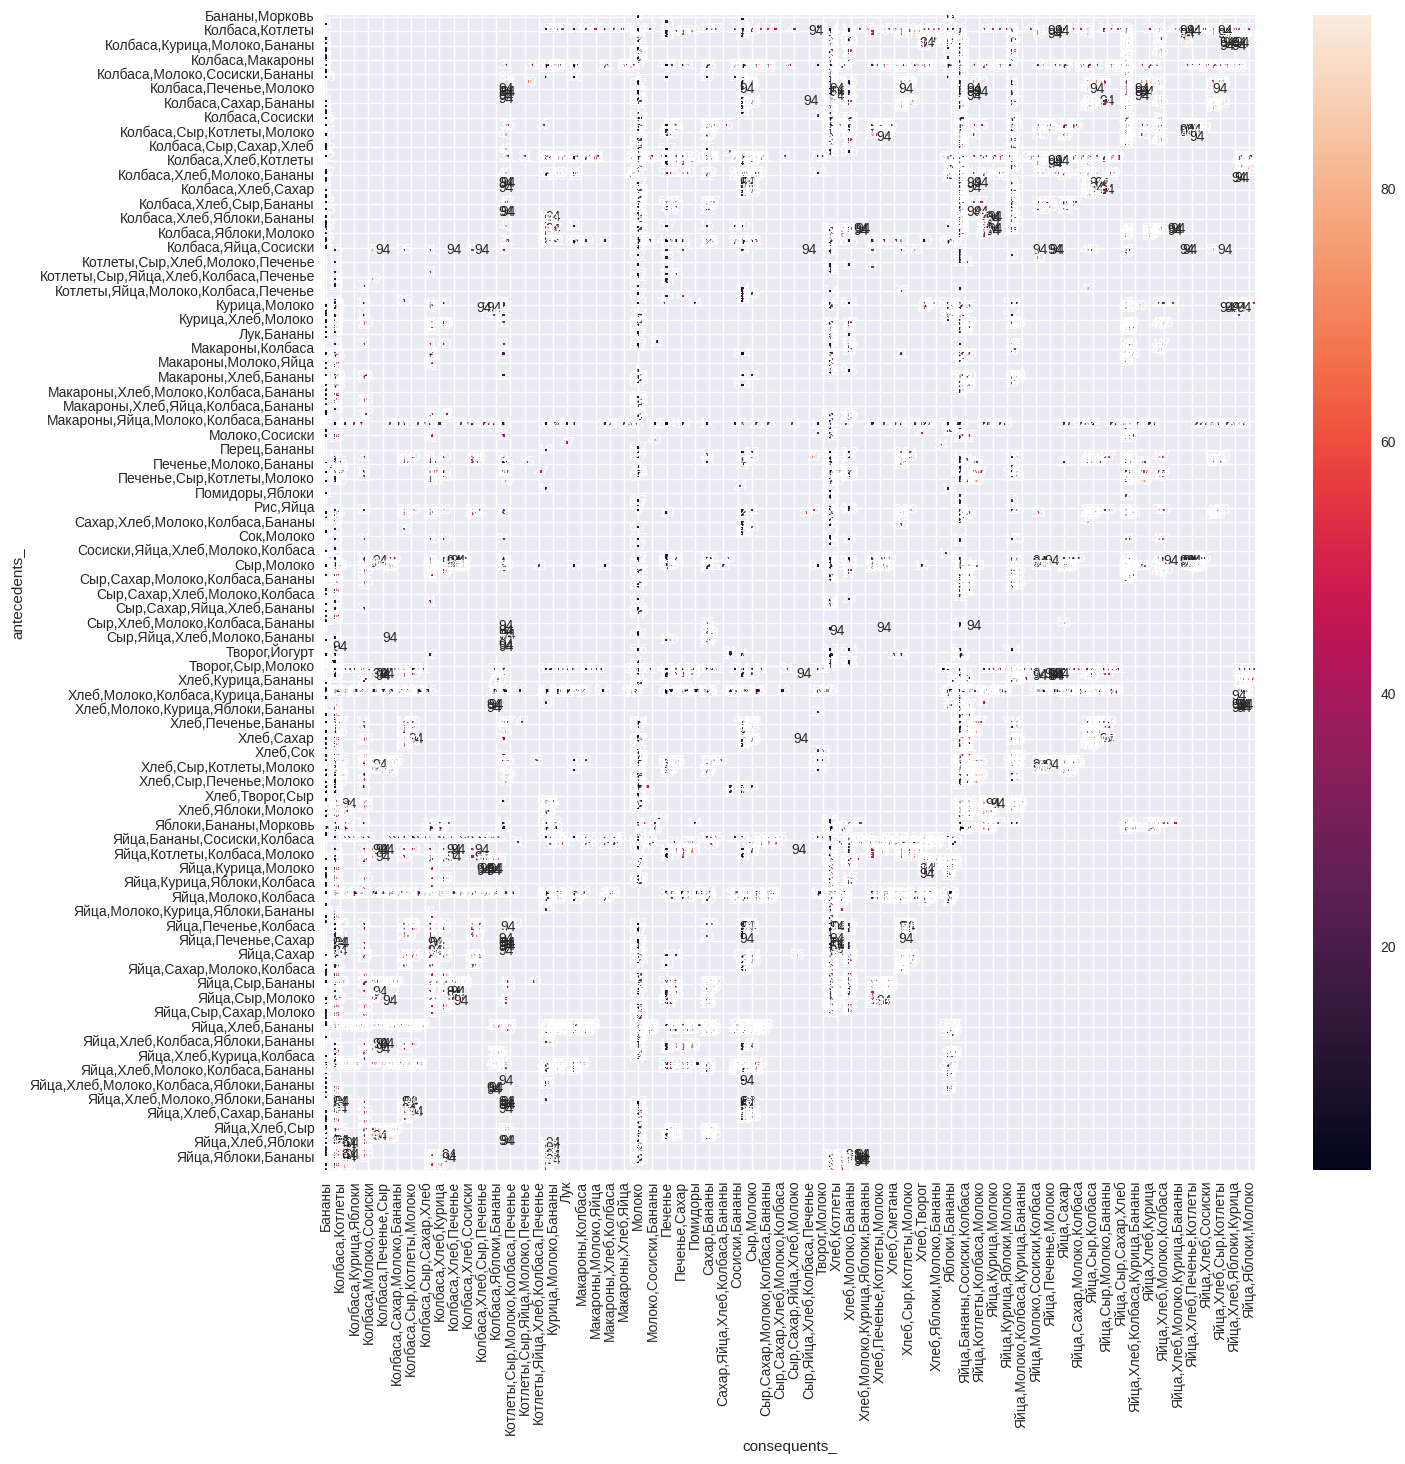

In [ ]:
apriori_rules['lhs_items'] = apriori_rules['antecedents'].apply(lambda x:len(x) )
apriori_rules[apriori_rules['lhs_items']>1].sort_values('lift', ascending=False).head()
apriori_rules['antecedents_'] = apriori_rules['antecedents'].apply(lambda a: ','.join(list(a)))
apriori_rules['consequents_'] = apriori_rules['consequents'].apply(lambda a: ','.join(list(a)))
pivot = apriori_rules[apriori_rules['lhs_items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Еще одна замечательная библиотека визуализации - это библиотека PyARMViz, которая может работать со сложными крупномасштабными правилами. Давайте сначала сгенерируем график параллельных категорий

In [ ]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

apriori_vis = apriori_rules

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 1034

transactions = [a[1]['Item'].tolist() for a in list(data.groupby(['Transaction', 'date_time']))]

def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()

rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules = []
for rd in rules_dict:
    rules.append(generate_rule_from_dict(rd))

PyARMViz.generate_parallel_category_plot(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


На основании полученных данных можем сделать несколько выводов по данным категориям:

1. **Частота комбинаций продуктов:**
   - На графиках видны частые сочетания продуктов, такие как хлеб, молоко, яйца и колбаса. Эти продукты могут быть классифицированы как базовые товары, которые часто покупают вместе.
   - Другие популярные пары включают сочетания молочных продуктов (например, сыр и молоко) и закусок (печенье, сахар).

2. **Взаимосвязь между категориями:**
   - Наблюдаются повторяющиеся связи между продуктами разных категорий: свежие продукты (яблоки, лук), молочные (молоко, сыр) и мясные (колбаса, курица). Эти комбинации, скорее всего, отражают покупки для составления полноценных блюд.

3. **Глубина сочетаний:**
   - На последних графиках видно увеличение сложности комбинаций с ростом числа "антецедентов" (предыдущих товаров). Например, комбинации "хлеб + молоко" часто дополняются сахаром, а затем печеньем.
   - Это говорит о том, что клиенты, покупающие базовые товары, склонны к добавлению сладостей и готовой еды.

4. **Сезонность и поведение:**
   - Хотя сезонные данные не представлены, можно предположить, что такие продукты, как курица, яблоки, морковь, могут больше присутствовать в зимний период для праздничных или семейных мероприятий.
   - Распределение связей может указывать на типичные корзины покупателей, например, для завтраков (хлеб, яйца, молоко) или обедов (курица, овощи, макароны).


Конечно, этот график гораздо полезнее с большим количеством ассоциативных правил.
Попробуем использовать тот же анализ на этот раз с минимальным порогом поддержки 0,5%.

In [ ]:
f_items = apriori(apriori_basket_set, min_support = 0.005, use_colnames = True)
apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 0.005, num_itemsets=len(apriori_basket_set))
apriori_rules.sort_values('confidence', ascending = False, inplace = True)

apriori_vis = apriori_rules

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 20507

transactions = [a[1]['Item'].tolist() for a in list(data.groupby(['Transaction', 'date_time']))]

def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()

rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

rules = []
for rd in rules_dict:
    rules.append(generate_rule_from_dict(rd))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [ ]:
PyARMViz.generate_parallel_category_plot(rules)

Теперь давайте взглянем на график сети для определения правил.

In [ ]:
PyARMViz.generate_rule_graph_plotly(rules)

Также график силы ассоциации, который представляет собой точечный график зависимости поддержки от уверенности с метрикой в качестве цветового измерения.

In [ ]:
PyARMViz.generate_rule_strength_plot(rules)